In [32]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# db
import pymongo

# configs & other
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import apply_filter
from utils import filter_instances
from utils import flatten_instances_df
from utils import df_rebase
from utils import rename_df_column_values

# utils visualization
from utils_visual import plot_instance_time_domain
from utils_visual import plot_instance_3d
from utils_visual import plot_np_instance
from utils_visual import plot_heatmap
from utils_visual import plot_scatter_pca

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Start time of execution

In [33]:
time_start = time()

## Load configuration

In [34]:
config_path = os.path.join(os.getcwd(), "config.yml")

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [35]:
client = pymongo.MongoClient(config["client"])
db = client[config["db"]]
coll = db[config["col"]]
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['class_A', 'class_B']


## Apply filter

In [36]:
# Sample code to apply filters on data fetched from MongoDB
data_cursor = coll.find()
data_list = list(data_cursor)

data_df_list = [pd.DataFrame(doc['data']) for doc in data_list]

filtered_data = filter_instances(data_df_list, order=config['filter']['order'], wn=config['filter']['wn'], filter_type=config['filter']['type'])
print("Filtered Data:", filtered_data)  # Print the filtered data

Number of filtered instances in the list: 1283
Filtered Data: [    x-axis (g)  y-axis (g)  z-axis (g)  x-axis (deg/s)  y-axis (deg/s)  \
0     0.680333    0.234405    0.776528        0.516664        0.477990   
1     0.668179    0.233492    0.768673        0.513287        0.493041   
2     0.653114    0.232057    0.758286        0.508761        0.511325   
3     0.635109    0.230001    0.745099        0.502949        0.532720   
4     0.614231    0.227236    0.728894        0.495733        0.556959   
..         ...         ...         ...             ...             ...   
65    0.889491    0.856542    0.785344        0.420043        0.419045   
66    0.890302    0.858000    0.787909        0.423005        0.418431   
67    0.890670    0.858656    0.789023        0.424380        0.418159   
68    0.890784    0.858861    0.789358        0.424820        0.418075   
69    0.890802    0.858893    0.789409        0.424889        0.418062   

    z-axis (deg/s)  
0         0.552546  
1     

## Transform the list of DataFrames to NumPy array
Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [37]:
windows = np.array([df.values for df in filtered_data])

print("Transformed Data to NumPy array shape:", windows.shape)
print("NumPy Array Data:", windows)

Transformed Data to NumPy array shape: (1283, 70, 6)
NumPy Array Data: [[[0.68033348 0.23440539 0.77652769 0.51666359 0.4779902  0.5525463 ]
  [0.66817857 0.23349189 0.76867333 0.5132872  0.49304125 0.56352041]
  [0.65311425 0.23205653 0.75828625 0.50876136 0.51132503 0.57668706]
  ...
  [0.89066958 0.85865643 0.7890226  0.42438038 0.41815868 0.52648879]
  [0.89078432 0.85886095 0.78935848 0.42481972 0.41807524 0.52635399]
  [0.89080218 0.85889273 0.78940931 0.42488927 0.41806244 0.52633271]]

 [[0.31667489 0.15999605 0.39681439 0.33693694 0.83587194 0.80220328]
  [0.30244383 0.15530449 0.3715692  0.32438173 0.84045085 0.80653827]
  [0.28725062 0.15036651 0.34278217 0.30970971 0.84425032 0.8110052 ]
  ...
  [0.88425795 0.91287721 0.63307245 0.69331092 0.41896787 0.42415981]
  [0.88411974 0.91283296 0.63258655 0.69354665 0.41898287 0.42401243]
  [0.88409763 0.91282558 0.63251042 0.69358301 0.41898501 0.42398931]]

 [[0.31490208 0.18586358 0.06642011 0.10661434 0.6698412  0.78658325]
  [

## Flatten the 2D window instances
Flatten the X NumPy array that contains the 2D window instances

In [38]:
flattened_data_df = flatten_instances_df(filtered_data)
flattened_data_np = flattened_data_df.to_numpy()

print("Flattened NumPy Array shape:", flattened_data_np.shape)
print("Flattened NumPy Array:", flattened_data_np)

Flattened NumPy Array shape: (1283, 420)
Flattened NumPy Array: [[0.68033348 0.23440539 0.77652769 ... 0.42488927 0.41806244 0.52633271]
 [0.31667489 0.15999605 0.39681439 ... 0.69358301 0.41898501 0.42398931]
 [0.31490208 0.18586358 0.06642011 ... 0.79092626 0.37261809 0.33134187]
 ...
 [0.34019917 0.3499172  0.26380014 ... 0.48398502 0.79110251 0.66832933]
 [0.42296828 0.40969629 0.17010496 ... 0.44749276 0.83821572 0.63060534]
 [0.40349662 0.43218241 0.19189622 ... 0.35577119 0.94960953 0.5518702 ]]


## Train/Test split

In [39]:
from sklearn.model_selection import train_test_split
X = flattened_data_df.to_numpy()

# Create dummy binary labels for illustration
y = np.ones(1283, dtype=int)
y[1:563]=0
y[564:1283]=1
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1026, 420)
X_test shape: (257, 420)
y_train shape: (1026,)
y_test shape: (257,)


## Scaling

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [41]:
scaler = StandardScaler()
# Alternatively, for Min-Max Scaling use:
# scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Dimensionality Reduction with PCA using the 1D (flattened) data

In [42]:
# add transformers
from sklearn.decomposition import PCA

In [43]:
#1D
pca1 = PCA(n_components=1)
X_train_pca1 = pca1.fit_transform(X_train_scaled)
X_test_pca1 = pca1.transform(X_test_scaled)

print("X_train_pca1 shape:", X_train_pca1.shape)
print("X_test_pca1 shape:", X_test_pca1.shape)

X_train_pca1 shape: (1026, 1)
X_test_pca1 shape: (257, 1)


### PCA with 3 Components

In [44]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are already defined

pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

train_pca_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2', 'PC3'])
train_pca_df['label'] = y_train

# Plot the PCA results using plotly for interactive rotation
fig = px.scatter_3d(train_pca_df, x='PC1', y='PC2', z='PC3', color='label', title='3D PCA Scatter Plot')
fig.update_traces(marker=dict(size=5))
fig.show()

X_train_pca shape: (1026, 3)
X_test_pca shape: (257, 3)
y_train shape: (1026,)
y_test shape: (257,)


### PCA with X% of the variance of the dataset, for training the statistical AI Models

In [45]:
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_pca shape: (1026, 15)
X_test_pca shape: (257, 15)
y_train shape: (1026,)
y_test shape: (257,)


## Classifier - Statistical Learning

### Apply simple classifier

In [46]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [47]:
svm_classifier = SVC()
svm_classifier.fit(X_train_pca, y_train)
y_pred_svm = svm_classifier.predict(X_test_pca)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_pca, y_train)
y_pred_rf = rf_classifier.predict(X_test_pca)

# Evaluate SVM Classifier
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_classification_report = classification_report(y_test, y_pred_svm)
print("SVM Classifier Accuracy:", svm_accuracy)
print("SVM Classification Report:\n", svm_classification_report)

# Evaluate Random Forest Classifier
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_classification_report = classification_report(y_test, y_pred_rf)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_classification_report)

SVM Classifier Accuracy: 0.9766536964980544
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       118
           1       0.96      1.00      0.98       139

    accuracy                           0.98       257
   macro avg       0.98      0.97      0.98       257
weighted avg       0.98      0.98      0.98       257

Random Forest Classifier Accuracy: 0.9727626459143969
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       118
           1       0.96      0.99      0.98       139

    accuracy                           0.97       257
   macro avg       0.97      0.97      0.97       257
weighted avg       0.97      0.97      0.97       257



### Evaluate simple classifier

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

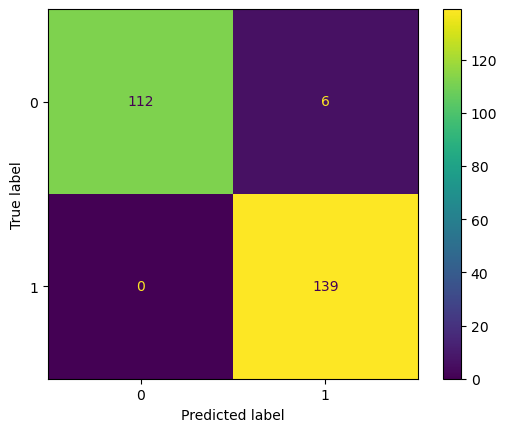

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       118
           1       0.96      1.00      0.98       139

    accuracy                           0.98       257
   macro avg       0.98      0.97      0.98       257
weighted avg       0.98      0.98      0.98       257



In [49]:
# Evaluate the classifier
y_pred = svm_classifier.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred))

### Apply optimization with Grid Search and Cross-validation

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
# # Define parameter grid
# param_grid = config['fine_tune']['param_grid']

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=config['fine_tune']['cv'], verbose=config['fine_tune']['verbose'])

# # Fit the model
# grid_search.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


### Evaluate optimized classifier

In [ ]:
# # Evaluate the optimized classifier
# best_svc = grid_search.best_estimator_
# y_pred_optimized = best_svc.predict(X_test_pca)
# cm_optimized = confusion_matrix(y_test, y_pred_optimized)
# disp_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_optimized)
# disp_optimized.plot()
# plt.show()

# print(classification_report(y_test, y_pred_optimized))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       113
           1       0.96      0.98      0.97       144

    accuracy                           0.97       257
   macro avg       0.97      0.97      0.97       257
weighted avg       0.97      0.97      0.97       257


## Classifier - Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

## Reshape Data for CNN
Reshape the flattened data into 2D shape for CNN (instances, x, y)

In [ ]:
X_train_2d = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_2d = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

print("X_train_2d shape:", X_train_2d.shape)
print("X_test_2d shape:", X_test_2d.shape)

X_train_2d shape: (1026, 0, 1)
X_test_2d shape: (257, 0, 1)


In [ ]:
y_np_array = np.array(y)
n_outputs = len(np.unique(y_np_array))
print("Number of outputs (classes) the model to predict:", n_outputs)

Number of outputs (classes) the model to predict: 2


### Create the Neural Network (NN) Architecture and instantiate the model

In [ ]:
model = tf.keras.models.Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_2d.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))


In [ ]:
# Build the model by calling it on a batch of data
model.build(input_shape=(None, X_train_2d.shape[1], 1))

Plot the Architecture of the TensorFlow model

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Plot the summary of the TensorFlow model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 0, 64)             256       
                                                                 
 max_pooling1d_2 (MaxPooling (None, 0, 64)             0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 0, 32)             6176      
                                                                 
 max_pooling1d_3 (MaxPooling (None, 0, 32)             0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 0)                 0         
                                                                 
 dense_2 (Dense)             (None, 128)              

### Build the NN model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
from utils import encode_labels
y_train_encoded = encode_labels(y_train)
y_test_encoded = encode_labels(y_test)

### Train the NN model

In [ ]:
history = model.fit(X_train_2d, y_train_encoded, epochs=config['fit']['epochs'], batch_size=config['fit']['batch'], validation_split=0.2, verbose=config['fit']['verbose'])

Epoch 1/10
33/33 [==============================] - 1s 7ms/step - loss: 0.6795 - accuracy: 0.6380 - val_loss: 0.5473 - val_accuracy: 0.7423
Epoch 2/10
33/33 [==============================] - 0s 3ms/step - loss: 0.5586 - accuracy: 0.7155 - val_loss: 0.4764 - val_accuracy: 0.7423
Epoch 3/10
33/33 [==============================] - 0s 3ms/step - loss: 0.4866 - accuracy: 0.7593 - val_loss: 0.4221 - val_accuracy: 0.7870
Epoch 4/10
33/33 [==============================] - 0s 3ms/step - loss: 0.4134 - accuracy: 0.8135 - val_loss: 0.3792 - val_accuracy: 0.8152
Epoch 5/10
33/33 [==============================] - 0s 3ms/step - loss: 0.3697 - accuracy: 0.8388 - val_loss: 0.3488 - val_accuracy: 0.8424
Epoch 6/10
33/33 [==============================] - 0s 3ms/step - loss: 0.3311 - accuracy: 0.8560 - val_loss: 0.3250 - val_accuracy: 0.8576
Epoch 7/10
33/33 [==============================] - 0s 3ms/step - loss: 0.2997 - accuracy: 0.8760 - val_loss: 0.3058 - val_accuracy: 0.8674
Epoch 8/10
33/33 [==

### Evaluate the model on the test data

In [ ]:
test_loss, test_acc = model.evaluate(X_test_2d, y_test_encoded)
print(f"Test accuracy: {test_acc:.4f}")

9/9 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.8899
Test accuracy: 0.8899


### Plot and interpret the learning curves: Loss and Accuracy based on the training and validation sets

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# End time of execution
time_end = time()
print(f"Total execution time: {time_end - time_start:.2f} seconds")

Total execution time: 2.58 seconds
